In [1]:
pip install brian2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.3 MB/s eta 0:00:00


In [2]:
from brian2 import *

# Network Parameters


In [3]:
# Total number of neurons
total_neurons = 2000

# Fraction of inhibitory neurons
inhibitory_fraction = 0.2

# Number of excitatory neurons
num_exc_neurons = int(total_neurons * (1.0 - inhibitory_fraction))

# Number of inhibitory neurons
num_inh_neurons = int(total_neurons * inhibitory_fraction)

# Fraction of neurons coding for decision
coding_fraction = 0.15

# Number of neurons in each decision pool
num_decision_neurons = int(coding_fraction * num_exc_neurons)

# Synapse Parameters


In [4]:
# Reversal potentials for synapses
rev_pot_exc = 0. * mV  # Excitatory
rev_pot_inh = -70. * mV  # Inhibitory

# Decay times for synapses
decay_ampa = 2.0 * ms
rise_nmda = 2.0 * ms
decay_nmda = 100.0 * ms
decay_gaba = 5.0 * ms

# NMDA saturation at high presynaptic firing rates
nmda_saturation = 0.5 * kHz

# Extracellular magnesium concentration
magnesium_conc = 1 * mmole

# External Noise Inputs


In [5]:
# Number of external Poisson neurons
num_external_neurons = 1000

# External Poisson rates for populations
ext_rate_exc = 2400 * Hz / num_external_neurons  # Excitatory
ext_rate_inh = 2400 * Hz / num_external_neurons  # Inhibitory


# Synaptic Conductances


In [6]:

conductance_ext_exc = 2.1 * nS  # External -> Excitatory (AMPA)
conductance_ext_inh = 1.62 * nS  # External -> Inhibitory (AMPA)
conductance_ee_ampa = 0.05 * nS / num_exc_neurons * 1600  # Excitatory -> Excitatory (AMPA)
conductance_ei_ampa = 0.04 * nS / num_exc_neurons * 1600  # Excitatory -> Inhibitory (AMPA)
conductance_ee_nmda = 0.165 * nS / num_exc_neurons * 1600  # Excitatory -> Excitatory (NMDA)
conductance_ei_nmda = 0.13 * nS / num_exc_neurons * 1600  # Excitatory -> Inhibitory (NMDA)
conductance_ie_gaba = 1.3 * nS / num_inh_neurons * 400  # Inhibitory -> Excitatory (GABA)
conductance_ii_gaba = 1.0 * nS / num_inh_neurons * 400  # Inhibitory -> Inhibitory (GABA)


# Neuron Parameters


In [7]:
# Membrane potentials
resting_potential = -70.0 * mV
firing_threshold = -50.0 * mV
reset_potential = -55.0 * mV

# Capacitance and leak conductance
capacitance_exc = 0.5 * nF  # Pyramidal cells (Excitatory)
capacitance_inh = 0.2 * nF  # Interneurons (Inhibitory)
leak_cond_exc = 25.0 * nS  # Excitatory
leak_cond_inh = 20.0 * nS  # Inhibitory

# Refractory periods
refractory_exc = 2.0 * ms  # Excitatory
refractory_inh = 1.0 * ms  # Inhibitory


# Stimulus and Simulation Parameters


In [8]:
# Stimulus coherence and rate parameters
coherence_level = 12.8
stimulus_std_dev = 4.0 * Hz
baseline_rate = 40.0 * Hz
max_stimulus_rate = 40.0 * Hz

# Stimulus timing
stimulus_interval = 50.0 * ms
stimulus_start = 1000 * ms
stimulus_end = 3000 * ms
total_runtime = 4000 * ms

# Synaptic Footprints


In [9]:
# Potentiation and depression factors
potentiation = 1.7
depression = 1.0 - coding_fraction * (potentiation - 1.0) / (1.0 - coding_fraction)


# Neuron Equations


In [10]:

eqs_exc = """
   label : integer (constant)  # Label for decision encoding populations
   dV/dt = (- leak_cond_exc * (V - resting_potential) - I_AMPA - I_NMDA - I_GABA - I_AMPA_ext + I_input) / capacitance_exc : volt (unless refractory)

   I_AMPA = s_AMPA * (V - rev_pot_exc) : amp
   ds_AMPA / dt = - s_AMPA / decay_ampa : siemens

   I_NMDA = conductance_ee_nmda * s_NMDA_tot * (V - rev_pot_exc) / ( 1 + exp(-0.062 * V/mvolt) * (magnesium_conc/mmole / 3.57) ) : amp
   s_NMDA_tot : 1

   I_GABA = s_GABA * (V - rev_pot_inh) : amp
   ds_GABA / dt = - s_GABA / decay_gaba : siemens

   I_AMPA_ext = s_AMPA_ext * (V - rev_pot_exc) : amp
   ds_AMPA_ext / dt = - s_AMPA_ext / decay_ampa : siemens

   I_input : amp

   ds_NMDA / dt = - s_NMDA / decay_nmda + nmda_saturation * x * (1 - s_NMDA) : 1
   dx / dt = - x / rise_nmda : 1
"""

eqs_inh = """
   dV/dt = (- leak_cond_inh * (V - resting_potential) - I_AMPA - I_NMDA - I_GABA - I_AMPA_ext) / capacitance_inh : volt (unless refractory)

   I_AMPA = s_AMPA * (V - rev_pot_exc) : amp
   ds_AMPA / dt = - s_AMPA / decay_ampa : siemens

   I_NMDA = conductance_ei_nmda * s_NMDA_tot * (V - rev_pot_exc) / ( 1 + exp(-0.062 * V/mvolt) * (magnesium_conc/mmole / 3.57) ): amp
   s_NMDA_tot : 1

   I_GABA = s_GABA * (V - rev_pot_inh) : amp
   ds_GABA / dt = - s_GABA / decay_gaba : siemens

   I_AMPA_ext = s_AMPA_ext * (V - rev_pot_exc) : amp
   ds_AMPA_ext / dt = - s_AMPA_ext / decay_ampa : siemens
"""


# Neuron Populations


In [11]:

# Create excitatory and inhibitory populations
exc_population = NeuronGroup(num_exc_neurons, model=eqs_exc, threshold='V > firing_threshold', reset='V = reset_potential', refractory=refractory_exc, method='euler', name='exc_population')
inh_population = NeuronGroup(num_inh_neurons, model=eqs_inh, threshold='V > firing_threshold', reset='V = reset_potential', refractory=refractory_inh, method='euler', name='inh_population')

# Define decision pools
exc_pool1 = exc_population[:num_decision_neurons]
exc_pool2 = exc_population[num_decision_neurons:2 * num_decision_neurons]
exc_pool3 = exc_population[2 * num_decision_neurons:]
exc_pool1.label = 0
exc_pool2.label = 1
exc_pool3.label = 2

# Synaptic Connections


In [12]:

# Excitatory -> Excitatory (AMPA)
syn_ee_ampa = Synapses(exc_population, exc_population, 'w : siemens', on_pre='s_AMPA += w', delay=0.5 * ms, method='euler', name='syn_ee_ampa')
syn_ee_ampa.connect()
syn_ee_ampa.w[:] = conductance_ee_ampa
syn_ee_ampa.w["label_pre == label_post and label_pre < 2"] = conductance_ee_ampa * potentiation
syn_ee_ampa.w["label_pre != label_post and label_post < 2"] = conductance_ee_ampa * depression

# Excitatory -> Inhibitory (AMPA)
syn_ei_ampa = Synapses(exc_population, inh_population, on_pre='s_AMPA += conductance_ei_ampa', delay=0.5 * ms, method='euler', name='syn_ei_ampa')
syn_ei_ampa.connect()

# Excitatory -> Excitatory (NMDA)
syn_ee_nmda = Synapses(exc_population, exc_population, on_pre='x_pre += 1', delay=0.5 * ms, method='euler', name='syn_ee_nmda')
syn_ee_nmda.connect(j='i')

# Dummy population for summed activity storage
nmda_sum_group = NeuronGroup(3, 's : 1', name='nmda_sum_group')

# Summing activity based on subpopulation labels
nmda_sum = Synapses(exc_population, nmda_sum_group, 's_post = s_NMDA_pre : 1 (summed)', name='nmda_sum')
nmda_sum.connect(j='label_pre')

# Propagate summed activity to NMDA synapses
nmda_set_total_e = Synapses(nmda_sum_group, exc_population, '''w : 1 (constant)
                               s_NMDA_tot_post = w * s_pre : 1 (summed)''', name='nmda_set_total_e')
nmda_set_total_e.connect()
nmda_set_total_e.w = 1
nmda_set_total_e.w["i == label_post and label_post < 2"] = potentiation
nmda_set_total_e.w["i != label_post and label_post < 2"] = depression

# Excitatory -> Inhibitory (NMDA)
nmda_set_total_i = Synapses(nmda_sum_group, inh_population, 's_NMDA_tot_post = s_pre : 1 (summed)', name='nmda_set_total_i')
nmda_set_total_i.connect()

# Inhibitory -> Excitatory (GABA)
syn_ie_gaba = Synapses(inh_population, exc_population, on_pre='s_GABA += conductance_ie_gaba', delay=0.5 * ms, method='euler', name='syn_ie_gaba')
syn_ie_gaba.connect()

# Inhibitory -> Inhibitory (GABA)
syn_ii_gaba = Synapses(inh_population, inh_population, on_pre='s_GABA += conductance_ii_gaba', delay=0.5 * ms, method='euler', name='syn_ii_gaba')
syn_ii_gaba.connect()

# External and Stimulus Inputs


In [13]:

# External noise inputs (fixed background rates)
ext_input_exc = PoissonInput(exc_population, 's_AMPA_ext', num_external_neurons, ext_rate_exc, conductance_ext_exc)
ext_input_inh = PoissonInput(inh_population, 's_AMPA_ext', num_external_neurons, ext_rate_inh, conductance_ext_inh)

# Stimulus input, updated every 50ms
stim_pool1 = PoissonGroup(num_decision_neurons, rates=0 * Hz, name='stim_pool1')
stim_pool2 = PoissonGroup(num_decision_neurons, rates=0 * Hz, name='stim_pool2')
stim_pool1.run_regularly("rates = int(t > stimulus_start and t < stimulus_end) * (baseline_rate + coherence_level / 100.0 * max_stimulus_rate + stimulus_std_dev * randn())", dt=stimulus_interval)
stim_pool2.run_regularly("rates = int(t > stimulus_start and t < stimulus_end) * (baseline_rate - coherence_level / 100.0 * max_stimulus_rate + stimulus_std_dev * randn())", dt=stimulus_interval)
syn_stim_pool1 = Synapses(stim_pool1, exc_pool1, on_pre='s_AMPA_ext += conductance_ext_exc', name='syn_stim_pool1')
syn_stim_pool1.connect(j='i')
syn_stim_pool2 = Synapses(stim_pool2, exc_pool2, on_pre='s_AMPA_ext += conductance_ext_exc', name='syn_stim_pool2')
syn_stim_pool2.connect(j='i')


# Initial Conditions


In [14]:
exc_population.s_NMDA_tot = decay_nmda * 10 * Hz * 0.2
inh_population.s_NMDA_tot = decay_nmda * 10 * Hz * 0.2
exc_population.V = firing_threshold - 2 * mV
inh_population.V = firing_threshold - 2 * mV


# Monitors


In [15]:
# Spike recording for excitatory neurons in decision populations
spike_monitor_pool1 = SpikeMonitor(exc_pool1, record=True)
spike_monitor_pool2 = SpikeMonitor(exc_pool2, record=True)

# Population activity recording
rate_monitor_pool1 = PopulationRateMonitor(exc_pool1)
rate_monitor_pool2 = PopulationRateMonitor(exc_pool2)

# Input recording
input_monitor_pool1 = StateMonitor(stim_pool1, 'rates', record=0, dt=1 * ms)
input_monitor_pool2 = StateMonitor(stim_pool2, 'rates', record=0, dt=1 * ms)


# Network Creation and Simulation


In [16]:

# Create Network object
network = Network(collect())
network.add(exc_population, inh_population, exc_pool1, exc_pool2, exc_pool3, syn_ee_ampa, syn_ei_ampa, syn_ee_nmda, nmda_sum_group, nmda_sum, nmda_set_total_e, nmda_set_total_i, syn_ie_gaba, syn_ii_gaba, ext_input_exc, ext_input_inh, stim_pool1, stim_pool2, syn_stim_pool1, syn_stim_pool2, spike_monitor_pool1, spike_monitor_pool2, rate_monitor_pool1, rate_monitor_pool2, input_monitor_pool1, input_monitor_pool2)

# Enable profiling
network.profiling = True

# Run simulation
network.run(total_runtime, report='stdout', profile=True)

# Display profiling summary if available
try:
    print(network.get_profiling_info())
except ValueError:
    print("No profiling info collected.")

Starting simulation at t=0. s for a duration of 4. s
2.2937 s (57%) simulated in 10s, estimated 7s remaining.
4. s (100%) simulated in 16s
[('exc_population_stateupdater', 2.27723193 * second), ('poissoninput', 1.67863607 * second), ('syn_ee_ampa_pre', 0.84162879 * second), ('ratemonitor', 0.76305079 * second), ('inh_population_stateupdater', 0.74600339 * second), ('nmda_set_total_e_summed_variable_s_NMDA_tot_post', 0.59056067 * second), ('poissoninput_1', 0.58709931 * second), ('syn_ie_gaba_pre', 0.55940509 * second), ('ratemonitor_1', 0.55503726 * second), ('nmda_sum_summed_variable_s_post', 0.50714922 * second), ('spikemonitor', 0.4939301 * second), ('syn_stim_pool1_pre', 0.45437837 * second), ('syn_stim_pool2_pre', 0.44324255 * second), ('syn_ei_ampa_pre', 0.43670964 * second), ('syn_ii_gaba_pre', 0.41848564 * second), ('stim_pool1_spike_thresholder', 0.41180968 * second), ('stim_pool2_spike_thresholder', 0.40356994 * second), ('spikemonitor_1', 0.40340805 * second), ('syn_ee_nmda_

# Visualization of the Results


INFO       width adjusted from 50. ms to 50.1 ms [brian2.monitors.ratemonitor.adjusted_width]


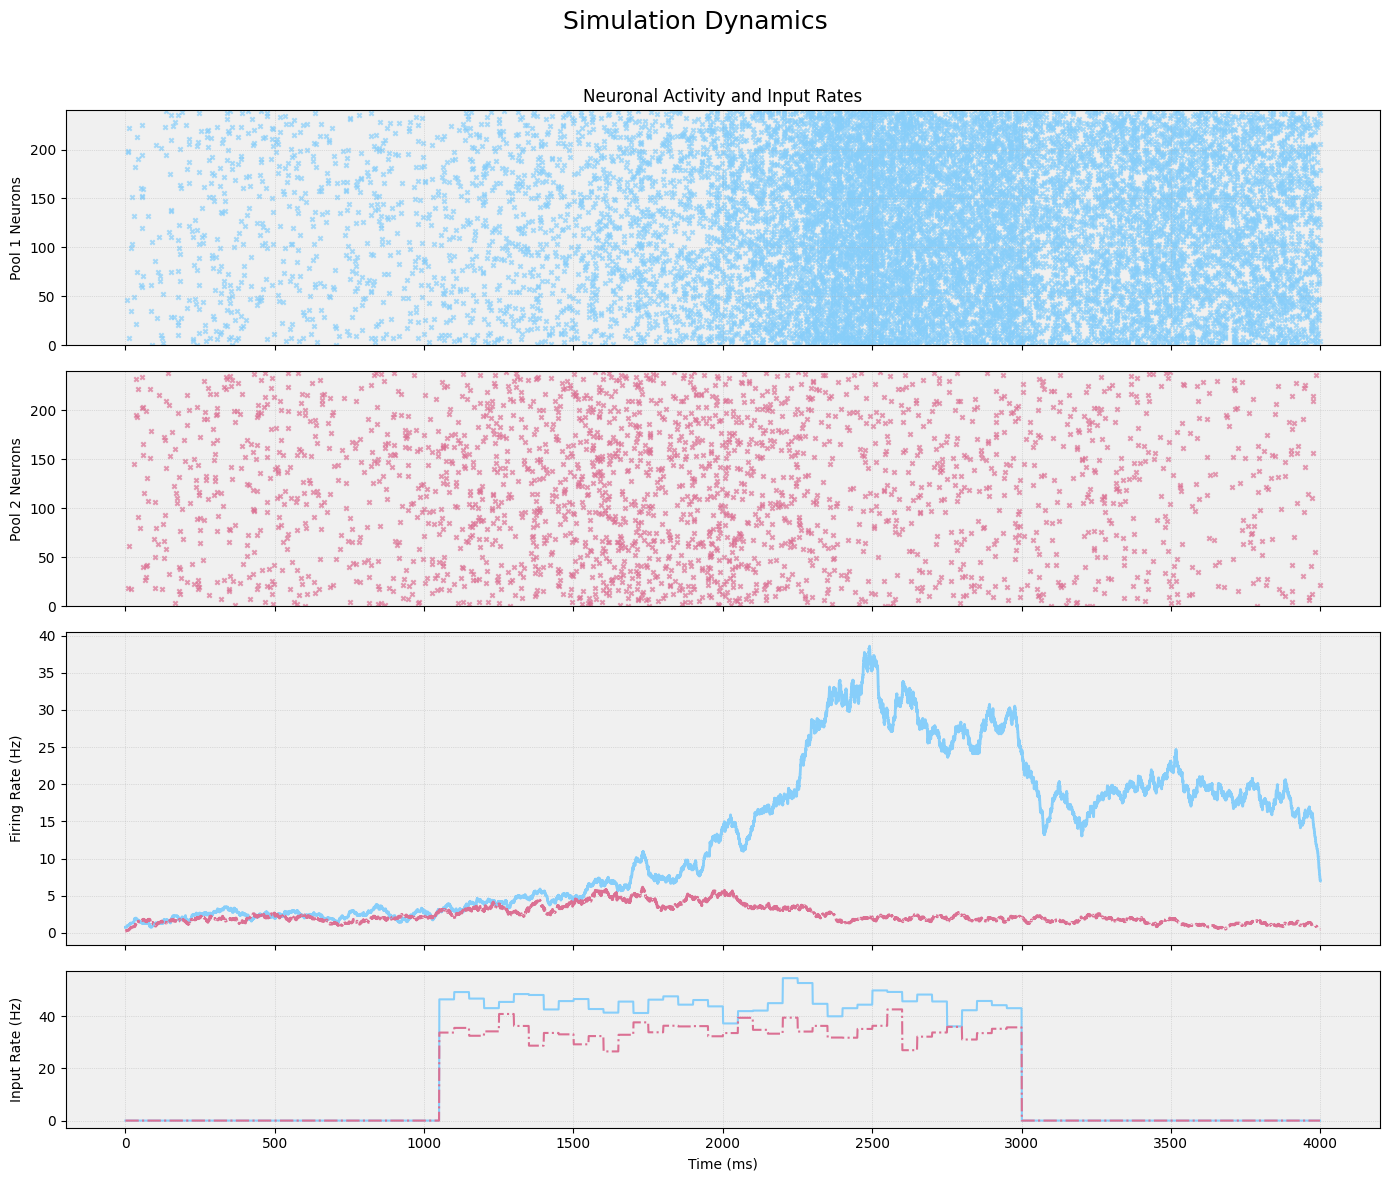

In [17]:

# Configure the plot with different styles
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(14, 12), gridspec_kw={'height_ratios': [1.5, 1.5, 2, 1]})

# Spike raster plots with distinct marker styles and colors
axes[0].scatter(spike_monitor_pool1.t / ms, spike_monitor_pool1.i, marker='x', s=10, color='lightskyblue', alpha=0.7)
axes[0].set_ylabel('Pool 1 Neurons')
axes[0].set_ylim([0, num_decision_neurons])
axes[0].set_title('Neuronal Activity and Input Rates')

axes[1].scatter(spike_monitor_pool2.t / ms, spike_monitor_pool2.i, marker='x', s=10, color='palevioletred', alpha=0.7)
axes[1].set_ylabel('Pool 2 Neurons')
axes[1].set_ylim([0, num_decision_neurons])

# Population activity with varied line styles and colors
axes[2].plot(rate_monitor_pool1.t / ms, rate_monitor_pool1.smooth_rate(window='flat', width=50 * ms) / Hz, linestyle='-', linewidth=2, color='lightskyblue')
axes[2].plot(rate_monitor_pool2.t / ms, rate_monitor_pool2.smooth_rate(window='flat', width=50 * ms) / Hz, linestyle='-.', linewidth=2, color='palevioletred')
axes[2].set_ylabel('Firing Rate (Hz)')

# Input rates with new line styles and colors
axes[3].plot(input_monitor_pool1.t / ms, input_monitor_pool1.rates[0] / Hz, linestyle='-', linewidth=1.5, color='lightskyblue')
axes[3].plot(input_monitor_pool2.t / ms, input_monitor_pool2.rates[0] / Hz, linestyle='-.', linewidth=1.5, color='palevioletred')
axes[3].set_ylabel('Input Rate (Hz)')
axes[3].set_xlabel('Time (ms)')

# Customizing the plot layout and labels
fig.align_ylabels(axes)
fig.suptitle('Simulation Dynamics', fontsize=18)

# Adding grid, background color, and legend
for ax in axes:
    ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
    ax.set_facecolor('#f0f0f0')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
